# Un arbre de décision en réseaux de neurones

L'idée est de convertir sous la forme d'un réseaux de neurones un arbre de décision puis de continuer l'apprentissage de façon à obtenir un assemblage de régression logistique plutôt que de décision binaire.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline
from jyquickhelper import RenderJsDot
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm

## Un exemple sur Iris

La méthode ne marche sur un problème de classification binaire.

In [3]:
from sklearn.datasets import load_iris
data = load_iris()
X, y = data.data[:, :2], data.target
y = y % 2

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [5]:
from sklearn.tree import DecisionTreeClassifier
dec = DecisionTreeClassifier(max_depth=2, random_state=11)
dec.fit(X_train, y_train)
dec.score(X_test, y_test)

0.6052631578947368

In [6]:
from sklearn.tree import export_graphviz
dot = export_graphviz(dec, filled=True)
dot = dot.replace("shape=box, ", "shape=box, fontsize=10, ")
RenderJsDot(dot)

## Même exemple en réseau de neurones

In [7]:
from mlstatpy.ml.neural_tree import NeuralTreeNet
net = NeuralTreeNet.create_from_tree(dec)
RenderJsDot(net.to_dot())

On considère une entrée en particulier.

In [8]:
n = 60
dec.predict_proba(X[n: n+1])

array([[0.27906977, 0.72093023]])

In [9]:
RenderJsDot(net.to_dot(X=X[n]))

In [10]:
dec.predict_proba(X_test)[:5]

array([[0.75      , 0.25      ],
       [0.75      , 0.25      ],
       [0.27906977, 0.72093023],
       [1.        , 0.        ],
       [0.27906977, 0.72093023]])

In [11]:
net.predict(X_test)[:5, -2:]

array([[0.79156817, 0.20843183],
       [0.73646978, 0.26353022],
       [0.29946111, 0.70053889],
       [0.94070094, 0.05929906],
       [0.24924737, 0.75075263]])

In [12]:
dec.predict_proba(X_test)[-5:]

array([[1.  , 0.  ],
       [0.75, 0.25],
       [1.  , 0.  ],
       [0.75, 0.25],
       [0.75, 0.25]])

In [13]:
net.predict(X_test)[-5:, -2:]

array([[0.93247891, 0.06752109],
       [0.86338585, 0.13661415],
       [0.98219036, 0.01780964],
       [0.98352807, 0.01647193],
       [0.73646978, 0.26353022]])

In [14]:
numpy.argmax(net.predict(X_test)[-5:, -2:], axis=1)

array([0, 0, 0, 0, 0], dtype=int64)

c:\python372_x64\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


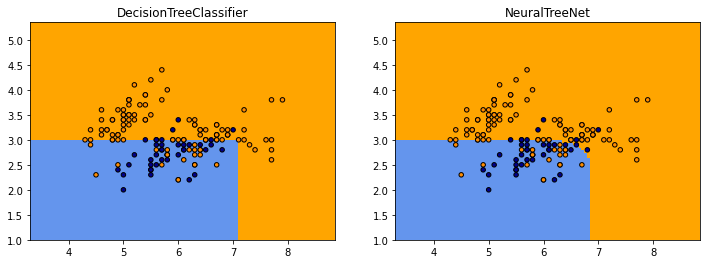

In [15]:
def plot_grid(X, y, fct, title, ax=None):
    
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])    

    h = .05
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h),
                            numpy.arange(y_min, y_max, h))
    Z = fct(numpy.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    if ax is None:
        _, ax = plt.subplots(1, 1)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_grid(X, y, dec.predict, dec.__class__.__name__, ax=ax[0])
plot_grid(X, y,
          lambda x: numpy.argmax(net.predict(x)[:, -2:], axis=1),
          net.__class__.__name__, ax=ax[1])

Le code qui produit les prédictions du réseau de neurones est assez long à exécuter mais il produit à peu près les mêmes frontières excepté qu'elles sont plus arrondies.

## Intermède de simples neurones de régression

Avant d'apprendre ou plutôt de continuer l'apprentissage des coefficients du réseaux de neurones, voyons comment un neurone se débrouille sur un problème de régression.

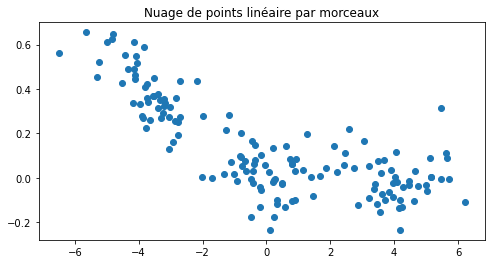

In [16]:
regX = numpy.empty((150, 1), dtype=numpy.float64)
regX[:50, 0] = numpy.random.randn(50) - 4
regX[50:100, 0] = numpy.random.randn(50)
regX[100:, 0] = numpy.random.randn(50) + 4
noise = numpy.random.randn(regX.shape[0]) / 10
regY = regX[:, 0] * -0.5 * 0.2 + noise
regY[regX[:, 0] > 0.3] = noise[regX[:, 0] > 0.3]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.set_title("Nuage de points linéaire par morceaux");

On cale une régression avec *scikit-learn*.

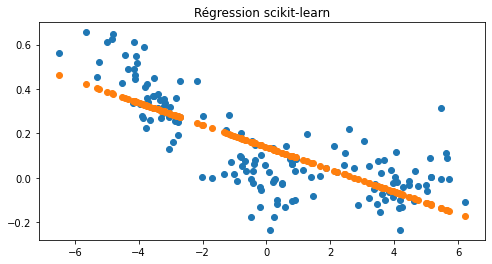

In [17]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(regX, regY)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.scatter(regX[:, 0], lr.predict(regX))
ax.set_title("Régression scikit-learn");

Et maintenant un neurone avec une fonction d'activation "identity".

In [18]:
from mlstatpy.ml.neural_tree import NeuralTreeNode
neu = NeuralTreeNode(1, activation="identity")
neu

NeuralTreeNode(weights=array([0.60837151]), bias=-1.1294931047949746, activation='identity')

In [19]:
neu.fit(regX, regY, verbose=True, max_iter=20)

0/20: loss: 929.2 lr=0.002 max(coef): 1.129
1/20: loss: 3.077 lr=0.000163 max(coef): 0.1235
2/20: loss: 2.876 lr=0.000115 max(coef): 0.1247
3/20: loss: 2.919 lr=9.42e-05 max(coef): 0.1275
4/20: loss: 2.825 lr=8.16e-05 max(coef): 0.131
5/20: loss: 2.869 lr=7.3e-05 max(coef): 0.1339
6/20: loss: 2.84 lr=6.66e-05 max(coef): 0.1343
7/20: loss: 2.894 lr=6.17e-05 max(coef): 0.1357
8/20: loss: 2.875 lr=5.77e-05 max(coef): 0.1361
9/20: loss: 2.839 lr=5.44e-05 max(coef): 0.1377
10/20: loss: 2.828 lr=5.16e-05 max(coef): 0.1369
11/20: loss: 2.831 lr=4.92e-05 max(coef): 0.1378
12/20: loss: 2.818 lr=4.71e-05 max(coef): 0.1389
13/20: loss: 2.819 lr=4.53e-05 max(coef): 0.1364
14/20: loss: 2.829 lr=4.36e-05 max(coef): 0.1358
15/20: loss: 2.819 lr=4.22e-05 max(coef): 0.1351
16/20: loss: 2.829 lr=4.08e-05 max(coef): 0.1335
17/20: loss: 2.83 lr=3.96e-05 max(coef): 0.1328
18/20: loss: 2.826 lr=3.85e-05 max(coef): 0.1349
19/20: loss: 2.825 lr=3.75e-05 max(coef): 0.1363
20/20: loss: 2.819 lr=3.65e-05 max(coe

NeuralTreeNode(weights=array([-0.05102527]), bias=0.13690028978271412, activation='identity')

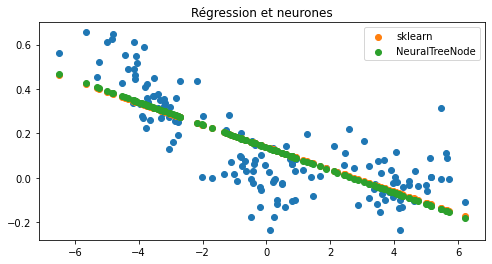

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.scatter(regX[:, 0], lr.predict(regX), label="sklearn")
ax.scatter(regX[:, 0], neu.predict(regX), label="NeuralTreeNode")
ax.legend()
ax.set_title("Régression et neurones");

Et avec d'autres fonctions d'activation...

In [21]:
neus = {'identity': neu}
for act in tqdm(['relu', 'leakyrelu', 'sigmoid']):
    nact = NeuralTreeNode(1, activation=act)
    nact.fit(regX, regY)
    neus[act] = nact

100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


In [22]:
neus['relu'], neus['leakyrelu']

(NeuralTreeNode(weights=array([-0.11921977]), bias=-0.06480161783085508, activation='relu'),
 NeuralTreeNode(weights=array([-0.10546549]), bias=-0.004911010378026508, activation='leakyrelu'))

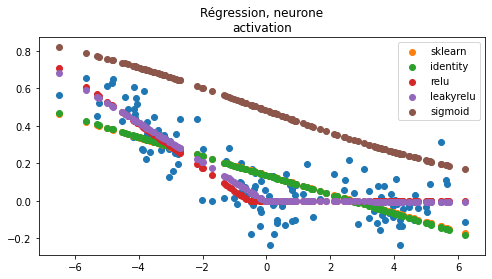

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(regX[:, 0], regY)
ax.scatter(regX[:, 0], lr.predict(regX), label="sklearn")
for k, v in neus.items():
    ax.scatter(regX[:, 0], v.predict(regX), label=k)
ax.legend()
ax.set_title("Régression, neurone\nactivation");

Rien de surprenant. La fonction sigmoïde prend ses valeurs entre 0 et 1. La fonction *relu* est parfois nulle sur une demi-droite, dès que la fonction est nulle sur l'ensemble du nuage de points, le gradient est nul partout (voir [Rectifier (neural networks)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))). La fonction leaky relu est définie comme suit :

$$f(x) = \left\{\begin{array}{l} x \, si \, x > 0 \\ \frac{x}{100} \, sinon \end{array}\right.$$

Le gradient n'est pas nul sur la partie la plus plate.

## Intermède de simples neurones de classification

Avant d'apprendre ou plutôt de continuer l'apprentissage des coefficients du réseaux de neurones, voyons comment un neurone se débrouille sur un problème de classification.

In [24]:
from sklearn.linear_model import LogisticRegression


clsX = numpy.empty((100, 2), dtype=numpy.float64)
clsX[:50] = numpy.random.randn(50, 2)
clsX[50:] = numpy.random.randn(50, 2) + 2
clsy = numpy.zeros(100, dtype=numpy.int64)
clsy[50:] = 1

logr = LogisticRegression()
logr.fit(clsX, clsy)
pred1 = logr.predict(clsX)

In [25]:
def line_cls(x0, x1, coef, bias):
    y0 = -(coef[0,0] * x0 + bias) / coef[0,1]
    y1 = -(coef[0,0] * x1 + bias) / coef[0,1]
    return x0, y0, x1, y1

x0, y0, x1, y1 = line_cls(-5, 5, logr.coef_, logr.intercept_)

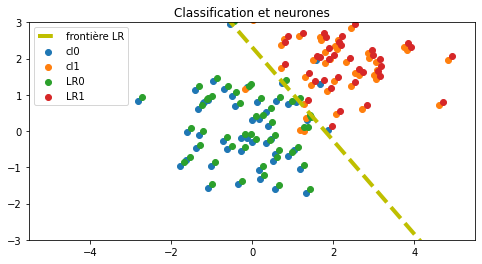

In [26]:
h = 0.1
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(clsX[clsy == 0, 0], clsX[clsy == 0, 1], label='cl0')
ax.scatter(clsX[clsy == 1, 0], clsX[clsy == 1, 1], label='cl1')
ax.scatter(clsX[pred1 == 0, 0] + h, clsX[pred1 == 0, 1] + h, label='LR0')
ax.scatter(clsX[pred1 == 1, 0] + h, clsX[pred1 == 1, 1] + h, label='LR1')
ax.plot([x0, x1], [y0, y1], 'y--', lw=4, label='frontière LR')
ax.set_ylim([-3, 3])
ax.legend()
ax.set_title("Classification et neurones");

Un neurone de classification binaire produit deux sorties, une pour chaque classe, et sont normalisées à 1. La fonction d'activation est la fonction [softmax](https://en.wikipedia.org/wiki/Softmax_function).

In [27]:
clsY = numpy.empty((clsy.shape[0], 2), dtype=numpy.float64)
clsY[:, 1] = clsy
clsY[:, 0] = 1 - clsy

In [28]:
softneu = NeuralTreeNode(2, activation='softmax')
softneu

NeuralTreeNode(weights=array([[-1.13305547, -1.03218058],
       [ 0.04768595, -2.2063421 ]]), bias=array([ 0.32667765, -2.10119485]), activation='softmax')

In [29]:
softneu.fit(clsX, clsY, verbose=True, max_iter=20, lr=0.001)

0/20: loss: 745.5 lr=0.001 max(coef): 2.206
1/20: loss: 174.1 lr=9.95e-05 max(coef): 4.91
2/20: loss: 167.3 lr=7.05e-05 max(coef): 5.769
3/20: loss: 167.3 lr=5.76e-05 max(coef): 6.11
4/20: loss: 165.5 lr=4.99e-05 max(coef): 6.398
5/20: loss: 165.6 lr=4.47e-05 max(coef): 6.635
6/20: loss: 165.3 lr=4.08e-05 max(coef): 6.839
7/20: loss: 166.1 lr=3.78e-05 max(coef): 7.014
8/20: loss: 166 lr=3.53e-05 max(coef): 7.175
9/20: loss: 165.9 lr=3.33e-05 max(coef): 7.328
10/20: loss: 165.4 lr=3.16e-05 max(coef): 7.479
11/20: loss: 164.6 lr=3.01e-05 max(coef): 7.618
12/20: loss: 164 lr=2.89e-05 max(coef): 7.753
13/20: loss: 164 lr=2.77e-05 max(coef): 7.872
14/20: loss: 164.2 lr=2.67e-05 max(coef): 7.995
15/20: loss: 163.8 lr=2.58e-05 max(coef): 8.111
16/20: loss: 163.5 lr=2.5e-05 max(coef): 8.226
17/20: loss: 163.6 lr=2.42e-05 max(coef): 8.331
18/20: loss: 164.1 lr=2.36e-05 max(coef): 8.421
19/20: loss: 163.6 lr=2.29e-05 max(coef): 8.518
20/20: loss: 162.8 lr=2.24e-05 max(coef): 8.622


NeuralTreeNode(weights=array([[4.04165198, 3.20293386],
       [7.45384894, 6.02257915]]), bias=array([8.62194837, 4.28542524]), activation='softmax')

In [30]:
pred = softneu.predict(clsX)
pred[:5]

array([[9.12184881e-01, 8.78151188e-02],
       [9.99603939e-01, 3.96061397e-04],
       [2.42055866e-01, 7.57944134e-01],
       [9.99969480e-01, 3.05196263e-05],
       [8.40757221e-01, 1.59242779e-01]])

In [31]:
pred2 = (pred[:, 1] > 0.5).astype(numpy.int64)

In [32]:
x00, y00, x01, y01 = line_cls(-4, 4, softneu.coef[:1, 1:], softneu.bias[0])
x10, y10, x11, y11 = line_cls(-4, 4, softneu.coef[1:, 1:], softneu.bias[1])
xa, ya, xb, yb = line_cls(
    -5, 5, softneu.coef[1:, 1:] - softneu.coef[:1, 1:],
    softneu.bias[1] - softneu.bias[0])

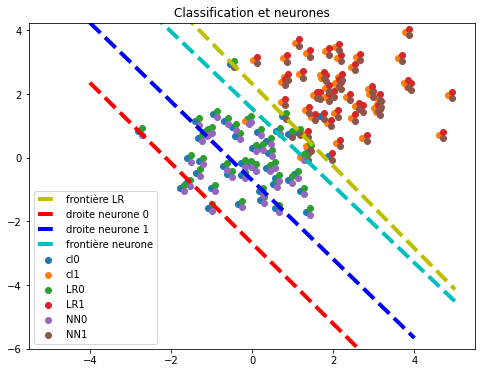

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(clsX[clsy == 0, 0], clsX[clsy == 0, 1], label='cl0')
ax.scatter(clsX[clsy == 1, 0], clsX[clsy == 1, 1], label='cl1')
ax.scatter(clsX[pred1 == 0, 0] + h, clsX[pred1 == 0, 1] + h, label='LR0')
ax.scatter(clsX[pred1 == 1, 0] + h, clsX[pred1 == 1, 1] + h, label='LR1')
ax.scatter(clsX[pred2 == 0, 0] + h, clsX[pred2 == 0, 1] - h, label='NN0')
ax.scatter(clsX[pred2 == 1, 0] + h, clsX[pred2 == 1, 1] - h, label='NN1')
ax.plot([x0, x1], [y0, y1], 'y--', lw=4, label='frontière LR')
ax.plot([x00, x01], [y00, y01], 'r--', lw=4, label='droite neurone 0')
ax.plot([x10, x11], [y10, y11], 'b--', lw=4, label='droite neurone 1')
ax.plot([xa, xb], [ya, yb], 'c--', lw=4, label='frontière neurone')
ax.set_ylim([max(-6, min([-3, y10, y11, y11, y01])),
             min(6, max([3, y10, y11, y11, y01]))])
ax.legend()
ax.set_title("Classification et neurones");

Ca marche. On vérifie en calculant le score. Le neurone a deux sorties. La frontière est définie par l'ensemble des points pour lesquels les deux sorties sont égales. Par conséquent, la distance entre les deux droites définies par les coefficients du neurone doivent être égales. Il existe une infinité de solutions menant à la même frontière.

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(clsy, logr.predict_proba(clsX)[:, 1])

0.9788

In [35]:
roc_auc_score(clsy, softneu.predict(clsX)[:, 1])

0.9776

## Apprentissage du réseau de neurones

Maintenant qu'on a vu les différentes fonctions d'activations et leur application sur des problèmes simples, on revient aux arbres convertis sous la forme d'un réseau de neurones. La prochaine étape est de pouvoir améliorer les performances du modèle issu de la conversion d'un arbre de classification avec un algorithme du gradient. On construit pour cela un nuage de points un peu traficoté.

In [36]:
clsX = numpy.empty((150, 2), dtype=numpy.float64)
clsX[:100] = numpy.random.randn(100, 2)
clsX[:20, 0] -= 1
clsX[20:40, 0] -= 0.8
clsX[:100, 1] /= 2
clsX[:100, 1] += clsX[:100, 0] ** 2
clsX[100:] = numpy.random.randn(50, 2)
clsX[100:, 0] /= 2
clsX[100:, 1] += 2.5
clsy = numpy.zeros(X.shape[0], dtype=numpy.int64)
clsy[100:] = 1

logr = LogisticRegression()
logr.fit(clsX, clsy)
pred1 = logr.predict(clsX)
logr.score(clsX, clsy)

0.76

In [37]:
x0, y0, x1, y1 = line_cls(-3, 3, logr.coef_, logr.intercept_)

c:\python372_x64\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


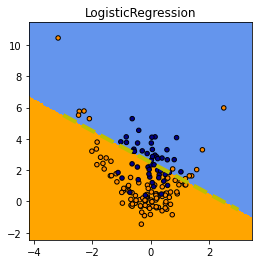

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_grid(clsX, clsy, logr.predict, logr.__class__.__name__, ax=ax)
ax.plot([x0, x1], [y0, y1], 'y--', lw=4, label='frontière LR');

Même chose avec un arbre de décision et le réseau de neurones converti.

In [39]:
dec = DecisionTreeClassifier(max_depth=2)
dec.fit(clsX, clsy)
pred2 = dec.predict(clsX)
dec.score(clsX, clsy)

0.9

In [40]:
net = NeuralTreeNet.create_from_tree(dec, 0.5)

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
(roc_auc_score(clsy, dec.predict_proba(clsX)[:, 1]),
 accuracy_score(clsy, dec.predict(clsX)))

(0.9315, 0.9)

In [43]:
(roc_auc_score(clsy, net.predict(clsX)[:, 1]),
 accuracy_score(clsy, numpy.argmax(net.predict(clsX)[:, -2:], axis=1)))

(0.8328, 0.7533333333333333)

c:\python372_x64\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


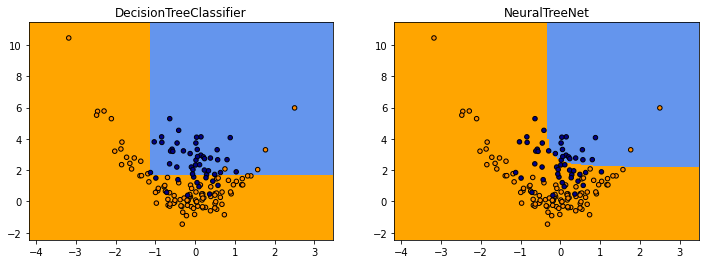

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_grid(clsX, clsy, dec.predict, dec.__class__.__name__, ax=ax[0])
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(net.predict(x)[:, -2:], axis=1),
          net.__class__.__name__, ax=ax[1])

Et on apprend le réseau de neurones en partant de l'arbre de départ.

In [45]:
from mlstatpy.ml.neural_tree import label_class_to_softmax_output
clsY = label_class_to_softmax_output(clsy)
clsY[:3]

array([[1., 0.],
       [1., 0.],
       [1., 0.]])

In [46]:
net2 = net.copy()
net2.fit(clsX, clsY, verbose=True, max_iter=30, lr=1e-5)

0/30: loss: 715.7 lr=1e-05 max(coef): 1
1/30: loss: 688.7 lr=8.14e-07 max(coef): 1.149
2/30: loss: 699.1 lr=5.76e-07 max(coef): 1.179
3/30: loss: 703.4 lr=4.71e-07 max(coef): 1.193
4/30: loss: 706.6 lr=4.08e-07 max(coef): 1.204
5/30: loss: 709.2 lr=3.65e-07 max(coef): 1.214
6/30: loss: 710.5 lr=3.33e-07 max(coef): 1.223
7/30: loss: 712.6 lr=3.08e-07 max(coef): 1.231
8/30: loss: 715 lr=2.89e-07 max(coef): 1.239
9/30: loss: 717.3 lr=2.72e-07 max(coef): 1.246
10/30: loss: 718.9 lr=2.58e-07 max(coef): 1.253
11/30: loss: 720.9 lr=2.46e-07 max(coef): 1.26
12/30: loss: 723.2 lr=2.36e-07 max(coef): 1.267
13/30: loss: 724.6 lr=2.26e-07 max(coef): 1.274
14/30: loss: 726.3 lr=2.18e-07 max(coef): 1.28
15/30: loss: 727.8 lr=2.11e-07 max(coef): 1.286
16/30: loss: 729.3 lr=2.04e-07 max(coef): 1.292
17/30: loss: 730.7 lr=1.98e-07 max(coef): 1.298
18/30: loss: 731.5 lr=1.92e-07 max(coef): 1.304
19/30: loss: 732.8 lr=1.87e-07 max(coef): 1.31
20/30: loss: 734.2 lr=1.83e-07 max(coef): 1.315
21/30: loss: 7

NeuralTreeNet(2)

c:\python372_x64\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


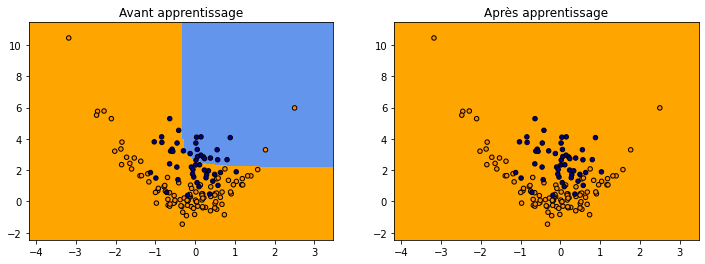

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(net.predict(x)[:, -2:], axis=1),
          "Avant apprentissage", ax=ax[0])
plot_grid(clsX, clsy,
          lambda x: numpy.argmax(net2.predict(x)[:, -2:], axis=1),
          "Après apprentissage", ax=ax[1])

Ca ne marche pas ou pas très bien. Il faudrait vérifier que la configuration actuelle ne se trouve pas dans un minimum locale auquel cas l'apprentissage par gradient ne donnera quasiment rien.

In [48]:
(roc_auc_score(clsy, net2.predict(clsX)[:, 1]),
 accuracy_score(clsy, numpy.argmax(net2.predict(clsX)[:, -2:], axis=1)))

(0.8328, 0.6666666666666666)

In [49]:
net2.predict(clsX)[-5:, -2:]

array([[0.75580743, 0.24419257],
       [0.78688454, 0.21311546],
       [0.77486773, 0.22513227],
       [0.78826818, 0.21173182],
       [0.91909152, 0.08090848]])

In [50]:
net.predict(clsX)[-5:, -2:]

array([[0.54085131, 0.45914869],
       [0.53771359, 0.46228641],
       [0.62108042, 0.37891958],
       [0.49166938, 0.50833062],
       [0.61319735, 0.38680265]])